In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh
from toss import setup_parameters

from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 


Using numpy backend


In [4]:
#args = get_parameters()
args = setup_parameters()
args.problem.number_of_maneuvers = 8

#x = [9.16234255e+03, 1.73917660e-02, 3.03363317e+00, 3.57741462e+00, 5.49214728e+00, 4.73909083e+00]
#x = [8.76679448e+03, 2.20679992e-02, 1.24754326e+00, 3.86373567e+00, 2.99297042e+00, 2.82755377e+00] #[9.24065403e+03, 3.28556596e-02, 1.96795951e+00, 4.55936911e+00, 3.26872264e+00, 2.30312127e+00]
x = np.genfromtxt('8M_champion_x.csv', delimiter=',')
#x = np.hstack((np.array([1.02346115e+04, 5.04262474e-01, 1.40521347e+00, 3.03148072e+00, 2.68878957e-01, 5.74690265e+00]), x))
#x = [5.24536306e+03, 2.04196908e-01, 1.58144741e+00, 4.82484233e+00, 1.24961743e+00, 2.56597493e-01]
collision_detected, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)

fitness_func = [FitnessFunctions.CloseDistancePenalty, FitnessFunctions.FarDistancePenalty, FitnessFunctions.CoveredSpace, FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty]
scaled_positions = np.empty((3*len(fitness_func), len(timesteps)), dtype=np.float64)
fitness_perturbation = np.arange(0,3,0.1)

fitness_array = np.empty((len(fitness_func), len(fitness_perturbation)))

for func_counter, func in enumerate(fitness_func):
    for perturb_counter, perturbation in enumerate(fitness_perturbation): # or some sensible range, you choose
        scaled_pos = perturbation*positions
        fitness = get_fitness(func, args, scaled_pos, velocities, timesteps)
        fitness_array[func_counter, perturb_counter] = fitness
       

ratio:  0.03676470588235294
weights:  2.148618290290945
ratio:  0.07457983193277311
weights:  2.042408315846108
ratio:  0.10084033613445378
weights:  1.524179112106564
ratio:  0.11134453781512606
weights:  1.280256990119282
ratio:  0.11029411764705882
weights:  0.9407590752756801
ratio:  0.10714285714285714
weights:  0.6895326975983453
ratio:  0.10399159663865547
weights:  0.5499175636491599
ratio:  0.0976890756302521
weights:  0.4305075888513735
ratio:  0.0976890756302521
weights:  0.3533553007612106
ratio:  0.08928571428571429
weights:  0.28134611788868724
ratio:  0.07142857142857142
weights:  0.20689077509403675
ratio:  0.059873949579831935
weights:  0.15163346022474689
ratio:  0.051470588235294115
weights:  0.11002743042818613
ratio:  0.0430672268907563
weights:  0.07154415684067562
ratio:  0.03571428571428571
weights:  0.051383601384243416
ratio:  0.026260504201680673
weights:  0.031571184882144505
ratio:  0.02100840336134454
weights:  0.02142845491468319
ratio:  0.018907563025210

In [5]:
args = setup_parameters()
args.problem.number_of_maneuvers = 8
x = np.genfromtxt('8M_champion_x.csv', delimiter=',')
collision_detected, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)
fitness = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("fitness: ", fitness)

ratio:  0.08928571428571429
weights:  0.28134611788868724
fitness:  0.37063183217440154


In [3]:
args = setup_parameters()
#args.problem.number_of_maneuvers = 8
x = np.genfromtxt('champion_x.csv', delimiter=',')
collision_detected, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)
fitness = get_fitness(FitnessFunctions.CoveredSpace, args, positions, velocities, timesteps)
print("fitness: ", fitness)

ratio:  0.03046218487394958
weights:  0.4252648391268567
fitness:  0.4557270240008063


In [5]:
#args = get_parameters()
args = setup_parameters()
x = np.genfromtxt('champion_x.csv', delimiter=',')

# Separate each chromosome representing an induvidual spacecraft:
list_of_spacecrafts = np.array_split(x, args.problem.number_of_spacecrafts)

# Resample and store trajectory for each spacecraft with a fixed time-step delta t
positions = None
velocities = None
timesteps = None

for counter, spacecraft in enumerate(list_of_spacecrafts):

    # Compute trajectory
    collision_detected, list_of_ode_objects, _ = compute_trajectory(spacecraft, args, compute_motion)
    
    # Resample trajectory for a fixed time-step delta t
    spacecraft_positions, spacecraft_velocities, spacecraft_timesteps = get_trajectory_fixed_step(args, list_of_ode_objects)

    # Store information
    if counter == 0:
        positions = spacecraft_positions
        velocities = spacecraft_velocities
        timesteps = spacecraft_timesteps

    else:
        positions = np.vstack((positions, spacecraft_positions))
        velocities = np.vstack((velocities, spacecraft_velocities))



[Text(0.5, 0, 'Scaling factor'),
 Text(0, 0.5, 'Fitness'),
 Text(0.5, 1.0, 'CoveredSpaceCloseDistancePenaltyFarDistancePenalty')]

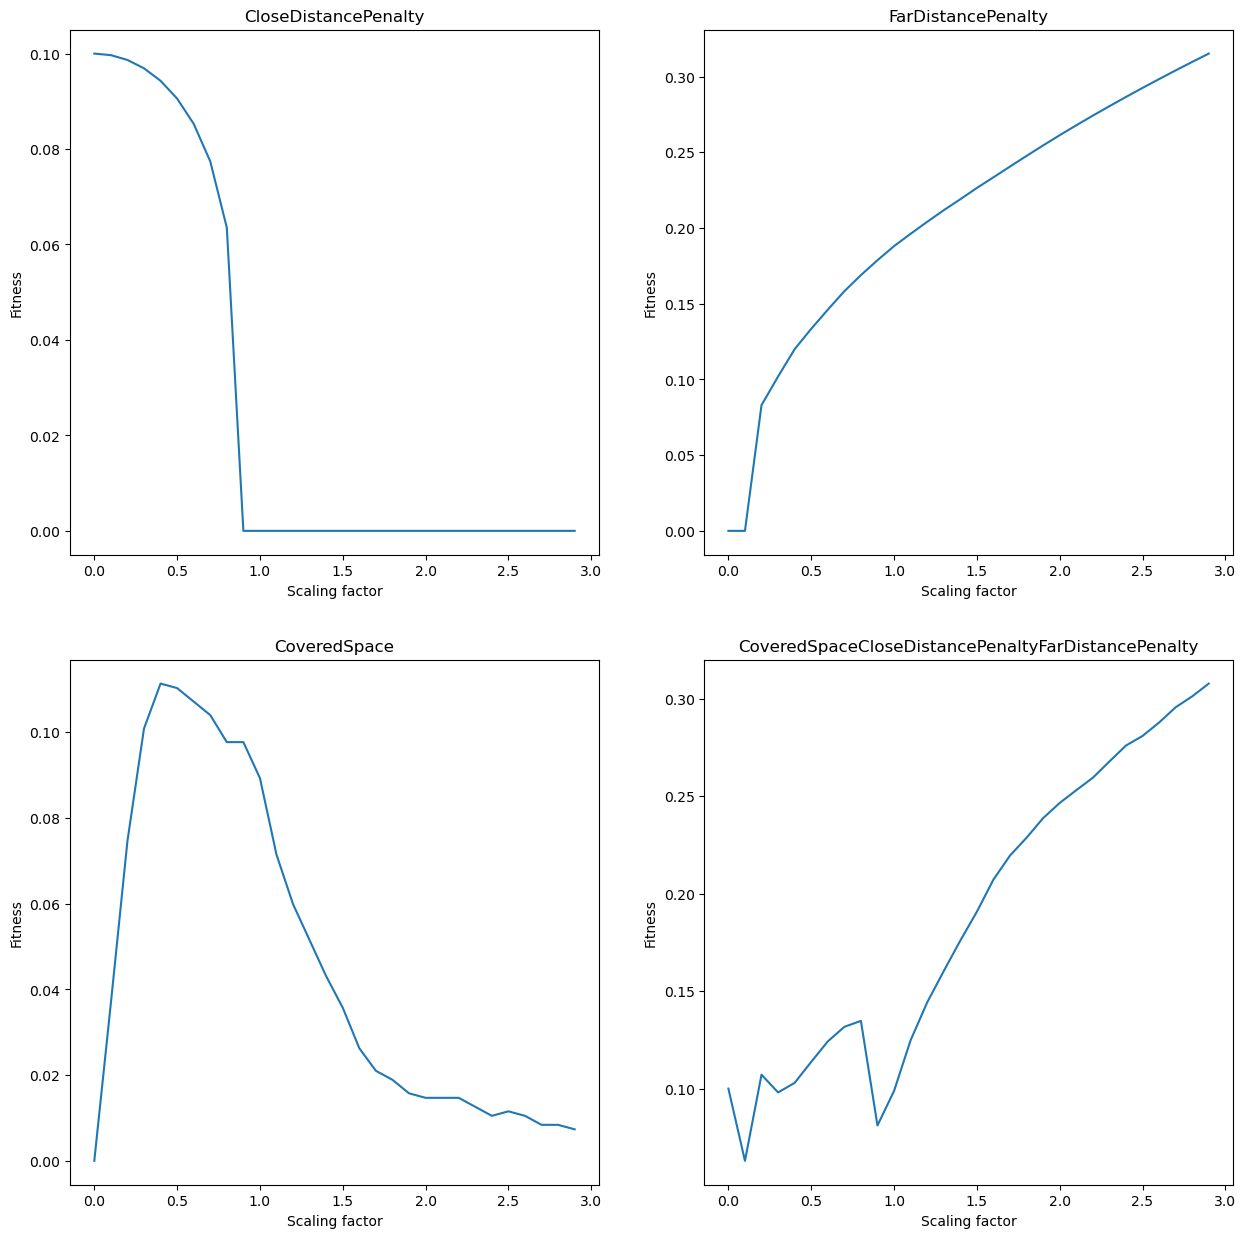

In [21]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0,0].plot(fitness_perturbation, fitness_array[0,:])
axes[0,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CloseDistancePenalty')

axes[0,1].plot(fitness_perturbation, fitness_array[1,:])
axes[0,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='FarDistancePenalty')

axes[1,0].plot(fitness_perturbation, fitness_array[2,:])
axes[1,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredSpace')

axes[1,1].plot(fitness_perturbation, fitness_array[3,:])
axes[1,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredSpaceCloseDistancePenaltyFarDistancePenalty')


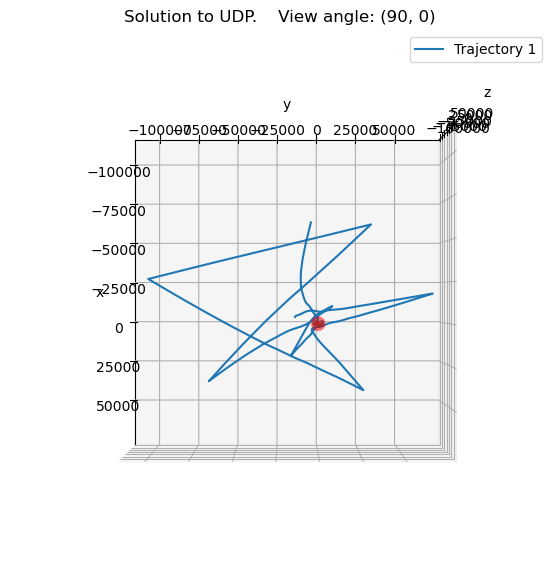

In [24]:
from toss import plot_UDP
plot_UDP(args, positions, True, True, True, False, [90,0], None)


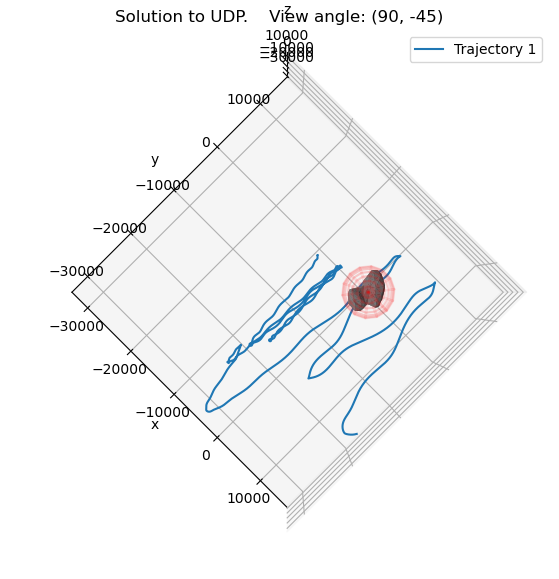

In [11]:
from toss import plot_UDP
plot_UDP(args, positions, True, True, True, False, [90,-45], None)

In [17]:
print(positions.shape)
print(velocities.shape)

semi_major_axis_list = []
import pykep as pk
for col in range(0, len(positions[0,:])):
    initial_states = pk.ic2par(r=positions[:,col], v=velocities[:,col], mu=args.body.mu)
    semi_major_axis_list.append(initial_states[0])


(3, 24192)
(3, 24192)


In [33]:
r = np.linspace(1000, 4000, int(5))
r_points = np.linspace(1000, 4000, int(50))

i = np.argmin(np.abs(r[:, np.newaxis] - r_points), axis=0)

print(i)
print(r[i])
print(np.sum(1/r[i]))

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1750. 1750. 1750. 1750. 1750.
 1750. 1750. 1750. 1750. 1750. 1750. 1750. 2500. 2500. 2500. 2500. 2500.
 2500. 2500. 2500. 2500. 2500. 2500. 2500. 3250. 3250. 3250. 3250. 3250.
 3250. 3250. 3250. 3250. 3250. 3250. 3250. 4000. 4000. 4000. 4000. 4000.
 4000. 4000.]
0.024099450549450556


In [1]:
def drawSphere(r):
    """ Generates (x,y,z) values for plotting a sphere of given radius r.
    Args:
        r (float): Radius of sphere.
    Returns:
        (x,y,z) (tuple): Arrays of values in cartesian frame, representing a sphere of radius r centered at origin.
    """
    #draw sphere
    u, v = np.mgrid[0:2*np.pi:15j, 0:np.pi:15j] #previously: 40j
    x=r*np.cos(u)*np.sin(v)
    y=r*np.sin(u)*np.sin(v)
    z=r*np.cos(v)

    return (x,y,z)


semi_major_axis_list = np.asarray(semi_major_axis_list)
idx = np.where(semi_major_axis_list < 3000)

risky_pos = positions[:,idx]

view_angle = [0,-45]



fig = plt.figure(figsize = (13,7))
ax = fig.add_subplot(projection='3d')

#Plot trajectory
id = 1
for i in range(0,len(risky_pos[:,0]),3):
    x = risky_pos[i,:]
    y = risky_pos[i+1,:]
    z = risky_pos[i+2,:]
    ax.scatter(x, y, z, s=1, label='Trajectory '+str(id))
    ax.legend()
    id += 1

# Plot mesh:
ax.plot_trisurf(args.mesh.vertices[:, 0], args.mesh.vertices[:,1], triangles=args.mesh.faces, Z=args.mesh.vertices[:,2], alpha=1, color='grey') 

# Plot risk zone:
r = args.problem.radius_inner_bounding_sphere
(x, y, z) = drawSphere(r)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

# Adjust viewangle of plot:
ax.view_init(view_angle[0],view_angle[1])

# Set title of figure:
ax.set_title("Solution to UDP.    View angle: ("+str(view_angle[0])+", "+str(view_angle[1])+")")

# Adjust axes limits and figure aspect
xyzlim = np.array([ax.get_xlim3d(),ax.get_ylim3d(),ax.get_zlim3d()]).T
XYZlim = [min(xyzlim[0]),max(xyzlim[1])]
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect("equal")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


NameError: name 'np' is not defined

In [10]:
import pykep as pk
# Separate initial state from chromosome and translate from osculating elements to cartesian frame.
r, v = pk.par2ic(E=x, mu=args.body.mu)
initial_state = np.array(r+v)
print(initial_state)
print(x[0:6])

ArgumentError: Python argument types in
    pykep.core.core.par2ic()
did not match C++ signature:
    par2ic(std::array<double, 6ul> E, double mu=1.0)

In [194]:
import pykep as pk
from toss import plot_UDP
from toss import get_trajectory_adaptive_step

# Setup problem parameters
args = get_parameters()
args.problem.start_time = 0                    
args.problem.final_time = 20000            
args.problem.number_of_maneuvers = 0 
args.problem.activate_rotation = True
args.problem.number_of_spacecrafts = 1
args.problem.measurement_period = 10              
args.problem.radius_inner_bounding_sphere = 4000      
args.problem.radius_outer_bounding_sphere = 15000

# Assign initial velocity
x = np.empty(6, dtype=np.float64)
x[0:3] = [5500, 0, 0]
x[3:6] = [0.1, -0.1, -0.3] # velocity that works: [0.44, 0.35, 0.4]

# Convert to osculating elements
x = pk.ic2par(r=x[0:3], v=x[3:6], mu=args.body.mu)
_, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
#positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)
states, timesteps = get_trajectory_adaptive_step(list_of_ode_pbjects)
positions = states[0:3, :]

In [ ]:
from toss import plot_UDP
l=[1,2]
for i in l:
    
    if i==1:
        args.problem.radius_inner_bounding_sphere = 4000
        args.mesh.mesh_path = 

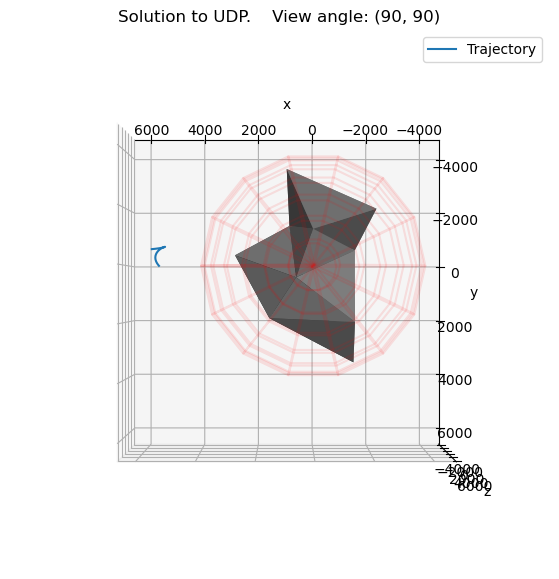

In [195]:
plot_UDP(args, positions, True, True, True, False, [90,90], None)

95


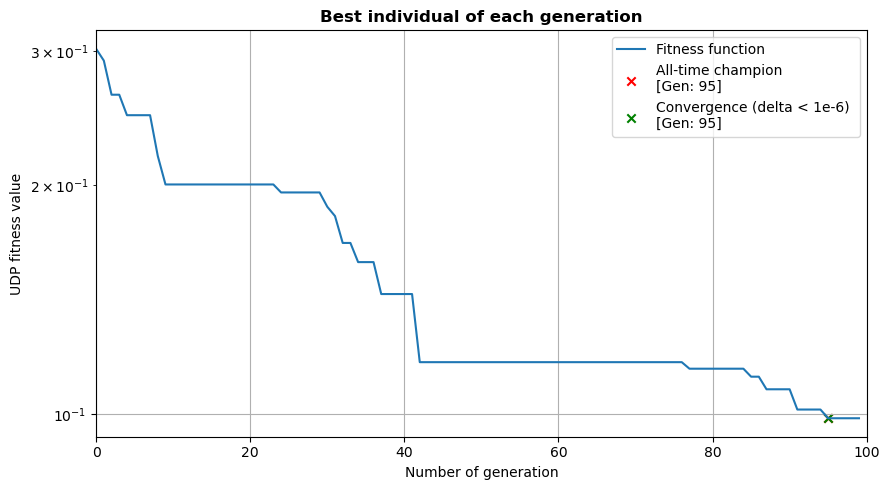

In [22]:
from toss import fitness_over_generations
import numpy as np 
fitness_list = np.genfromtxt('8M_fitness_list.csv', delimiter=',')
n_generations = 100
fitness_over_generations(fitness_list, n_generations)

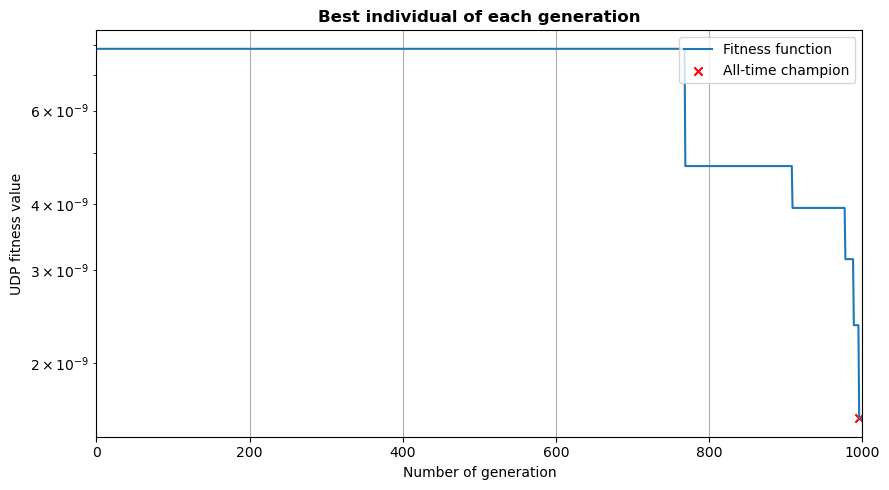

In [22]:
import numpy as np
fitness_list = np.genfromtxt
fitness_over_generations(np.flip(-1*fitness_list), n_generations)

[-4.71395750e-09 -7.85659584e-09 -7.85659584e-09]
